In [1]:
# import packages
import pandas as pd
import os
import glob
import random
import numpy as np
import statistics
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import ttest_rel
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import matplotlib.patches as mpatches

import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import statsmodels.formula.api as smf
from scipy import stats
from scipy.stats import norm

## Data Prep

In [2]:
# import word count .csv file from local path
path = r'/Users/spencersu/Desktop/Cincy'
wordcount = pd.read_csv(os.path.join(path, 'Cincy word count 19-22.csv'))

# remove column: the first column "Unnamed: 0"
wordcount = wordcount.iloc[:,1:18]

# 6980 rows × 17 columns

## change data type into integer: 'Word Count' column
# drop nan for Word Count column
wordcount = wordcount.dropna(subset=['Word Count'])

# replace ',' with ''
wordcount['Word Count'].replace(',','',regex=True,inplace=True)

# convert data type of word count column into integer
wordcount['Word Count'] = wordcount['Word Count'].astype(int)


##  create a function for repeated group by. 
def groupby_wc(df_togroup, groups):
    df = df_togroup.groupby(groups)['Word Count'].mean()
    df = pd.DataFrame(df)
    df = df.reset_index()
    return df
    
# create a subset for only teacher and student assignment ID
# because some assignments have a null value for teacher name, if groupby teacher, will reduce the number of assignments 
group1 = ['Teacher Name [Sensitive]','Student Assignment ID']
wc_teacher = groupby_wc(wordcount, group1)

wc_teacher.drop(['Word Count'],axis=1,inplace=True)


# remove rubric categories
    
group2 = ['School Year', 'School Name', 'Student ID','Full Name',
           'Enrolled Grade','Lesson ID', 'Writing Lesson Category','Student Assignment ID']
wordcount = groupby_wc(wordcount,group2)


# add teacher name back to df wordcount 
wordcount = pd.merge(wordcount, wc_teacher, on='Student Assignment ID',how='left')


# wordcnt dataset now has 720 rows × 10 columns
# data retrieved on Mar 22, 2022

In [3]:
wordcount

,School Year,School Name,Student ID,Full Name,Enrolled Grade,Lesson ID,Writing Lesson Category,Student Assignment ID,Word Count,Teacher Name [Sensitive]
0,2019-2020,Aiken High School,818464,Nia'Sya Canady,11,26280,Informational,13384160,161,NaN
1,2019-2020,Aiken High School,842320,Simbala Mangure,11,26280,Informational,13652252,201,NaN
2,2019-2020,Aiken High School,842452,Janel Yancey,11,19140,Other,13857722,88,NaN
3,2019-2020,Aiken High School,842452,Janel Yancey,11,26280,Informational,13384161,149,NaN
4,2019-2020,Aiken High School,842884,Andres Davis,11,26046,Argumentative,13664306,105,NaN
...,...,...,...,...,...,...,...,...,...,...
715,2021-2022,Woodward Career Technical HS,979477,Elijah Barnes,12,28432,Informational,15928365,80,Tia Richardson
716,2021-2022,Woodward Career Technical HS,982112,Jaylinn Crump,12,28432,Informational,15941598,80,Tia Richardson
717,2021-2022,Woodward Career Technical HS,1163136,Azucena Escobedo,12,28432,Informational,15928383,239,Tia Richardson
718,2021-2022,Woodward Career Technical HS,1244600,Ebrien White,10,28843,Argumentative,16139274,224,Berayah Yisrael


## Data Overview

In [4]:
# count unique number of student assignments and students
print(wordcount.groupby('School Year')['Student Assignment ID','Full Name'].nunique())
print(wordcount.groupby(['School Year','Enrolled Grade'])['Student Assignment ID','Full Name'].nunique())

             Student Assignment ID  Full Name
School Year                                  
2019-2020                      261        188
2020-2021                      182        145
2021-2022                      277        241
                            Student Assignment ID  Full Name
School Year Enrolled Grade                                  
2019-2020   7                                   1          1
            8                                  24         21
            9                                  48         44
            10                                 66         60
            11                                 39         25
            12                                 83         37
2020-2021   9                                   3          2
            10                                 22         20
            11                                 79         51
            12                                 77         71
            13                        

In [5]:
# word count overview by grades
wordcount.groupby(['School Year','Enrolled Grade'])['Word Count'].mean()

School Year  Enrolled Grade
2019-2020    7                 332.000000
             8                 364.958333
             9                 333.208333
             10                223.621212
             11                178.897436
             12                193.000000
2020-2021    9                  87.333333
             10                121.863636
             11                161.050633
             12                248.363636
             13                 56.000000
2021-2022    7                 212.120000
             8                 262.428571
             9                 119.121212
             10                149.770370
             11                104.181818
             12                113.538462
Name: Word Count, dtype: float64

## Boxplots

<Figure size 720x576 with 0 Axes>

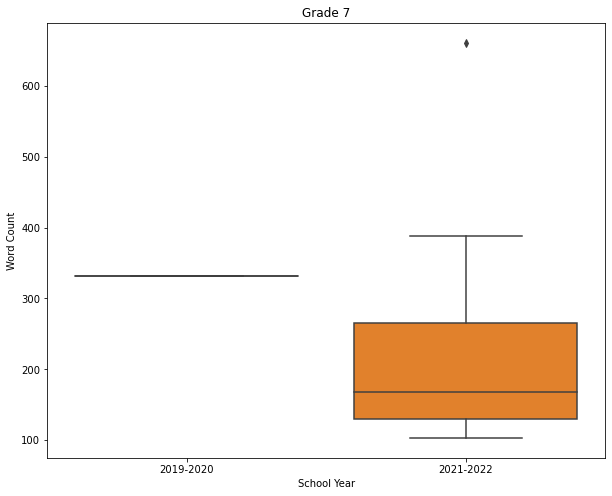

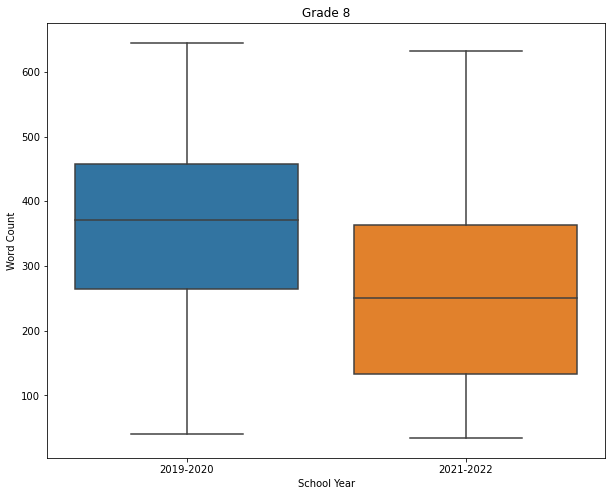

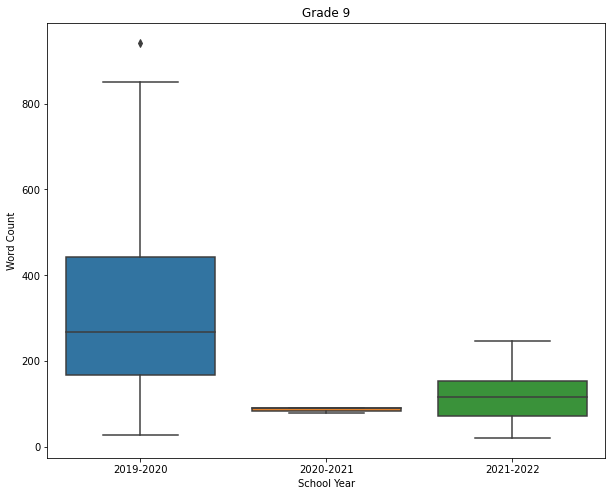

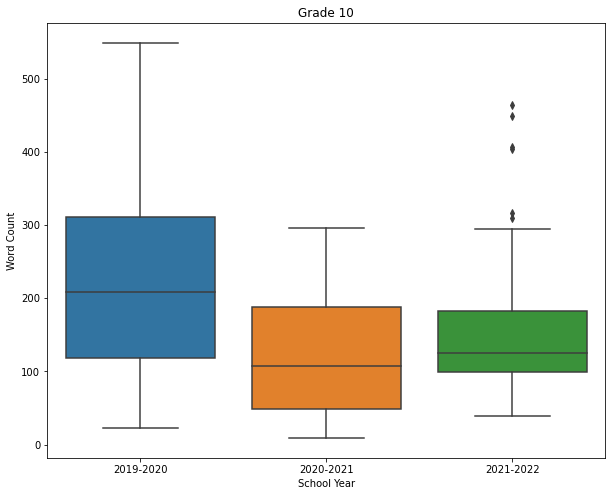

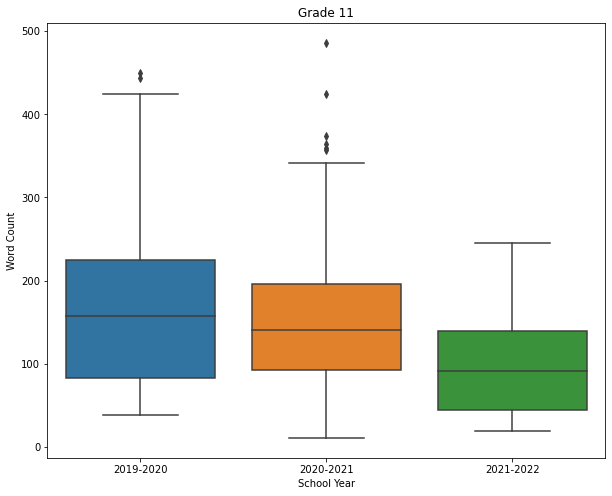

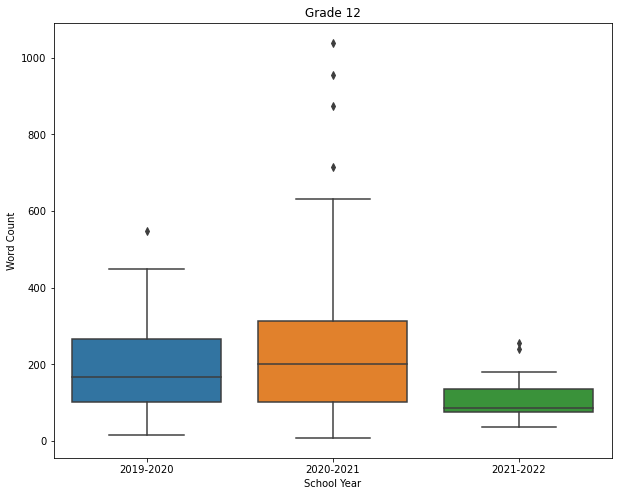

In [6]:
# boxplot: word count by school year (for each grade)
plt.figure(figsize = (10,8))

for n in range(7,13): 
    plt.figure(figsize = (10,8))
    # choose the grade  
    grade = wordcount[wordcount['Enrolled Grade']==n] 
    
    ax = sns.boxplot(x=grade['School Year'],y=grade['Word Count'])
    ax.set_title('Grade %d' %n)
#     plt.savefig('/Users/spencersu/Desktop/JCPS Efficacy Report/Datasets/boxplot grade' + str(n) +'.png')
    plt.show()

In [7]:
# drop column enrolled grade
group3 = ['School Year','School Name','Full Name']
pvt = groupby_wc(wordcount,group3)

# reshape, pivot
pvt = pvt.pivot(index=['School Name','Full Name'], columns='School Year', values='Word Count')

# drop all rows that include nan 
# pvt = pvt.dropna()

print(ttest_rel(pvt['2019-2020'], pvt['2020-2021']))
print(ttest_rel(pvt['2020-2021'], pvt['2021-2022']))
print(ttest_rel(pvt['2019-2020'], pvt['2021-2022']))

## t-test results have shown that there is a difference between each year, and the word count improves year by year

Ttest_relResult(statistic=nan, pvalue=nan)
Ttest_relResult(statistic=nan, pvalue=nan)
Ttest_relResult(statistic=nan, pvalue=nan)


In [8]:
pvt

School Year                                          2019-2020  2020-2021  \
School Name                  Full Name                                      
Aiken High School            Acki Meadows                  NaN     137.00   
                             Aeriona Sanks                 NaN     177.00   
                             Ajah Kemp               55.333333        NaN   
                             Alex Sebastian         300.000000     129.00   
                             Andres Davis           105.000000        NaN   
...                                                        ...        ...   
Woodward Career Technical HS Tahmya Burton                 NaN     131.75   
                             Terrah Adams                  NaN     120.00   
                             Thaddeus Baldwin              NaN        NaN   
                             William Martinez Diaz         NaN     290.00   
                             Yaco Rowland                  NaN        NaN   

School Year                                         2021-2022  
School Name                  Full Name                         
Aiken High School            Acki Meadows                 NaN  
                             Aeriona Sanks                NaN  
                             Ajah Kemp                    NaN  
                             Alex Sebastian               NaN  
                             Andres Davis                 NaN  
...                                                       ...  
Woodward Career Technical HS Tahmya Burton                NaN  
                             Terrah Adams               293.0  
                             Thaddeus Baldwin            85.0  
                             William Martinez Diaz        NaN  
                             Yaco Rowland               188.0  

[564 rows x 3 columns]

## Scatterplot (usage vs. word count)

In [23]:
## create a dataset for the number of assignments for each students, each school year

# subsets
wc_asgmt_a = wordcount.groupby(['School Year','School Name','Full Name'])['Word Count'].mean()
wc_asgmt_b = wordcount.groupby(['School Year','School Name','Full Name'])['Student Assignment ID'].count()

# merge
wc_asgmt = pd.merge(wc_asgmt_a,wc_asgmt_b,on=['School Year','School Name','Full Name'], how='inner')
wc_asgmt = wc_asgmt.reset_index()
wc_asgmt.rename(columns={wc_asgmt.columns[4]: 'num_asgmt'}, inplace = True)

In [24]:
## remove number of assignments equals 8 
# wc_asgmt = wc_asgmt[wc_asgmt['num_asgmt'] != 8]

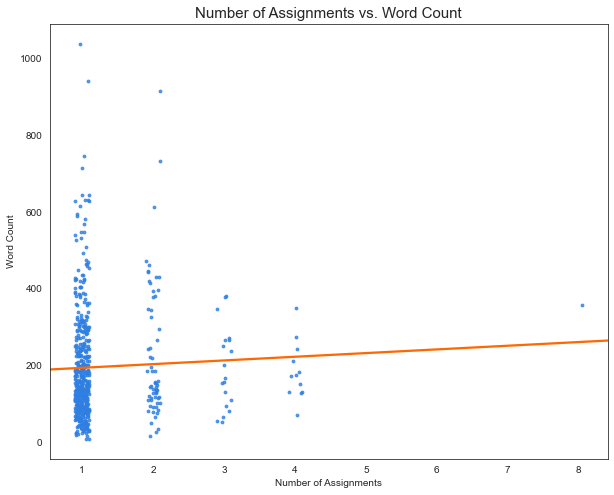

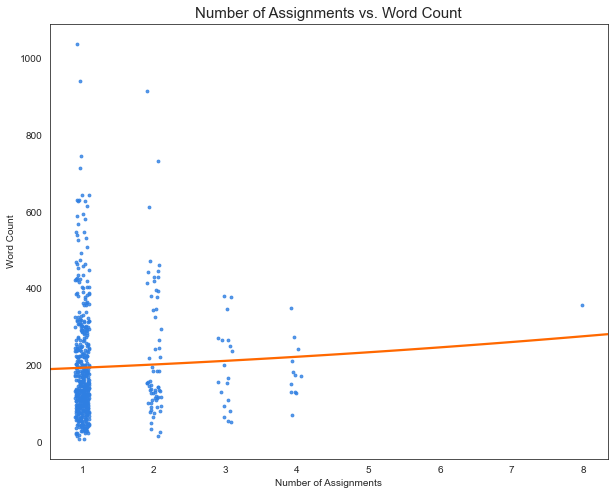

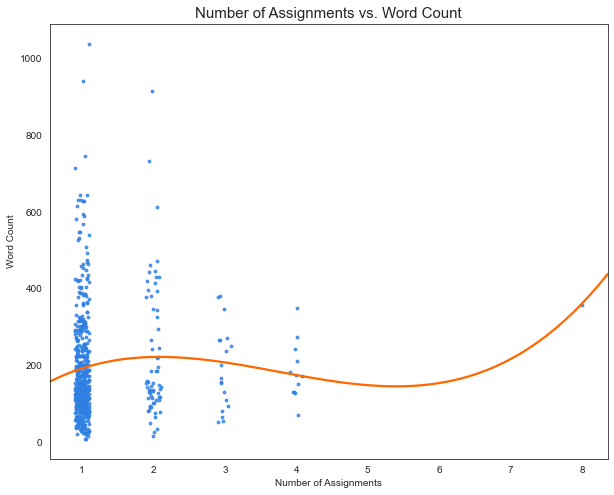

In [32]:
for n in range (1,4):
    sns.set_style(style='white')
    plt.figure(figsize = (10,8))
    sns.regplot(wc_asgmt['num_asgmt'],wc_asgmt['Word Count'], order = n,
                scatter_kws={"color": "#2f7fe2",'s':8}, truncate = False, x_jitter=.1,marker='o',
                line_kws={"color": "#ff6800"}, ci=None)
    plt.xlabel('Number of Assignments')
    plt.ylabel('Word Count')
    plt.title("Number of Assignments vs. Word Count", fontsize=15)
    plt.savefig(os.path.join(path,'The Number of Assignments vs. Word Count (Order ' + str(n) +').png'))
    plt.show()

## Regression

In [26]:
wc_reg_a = wordcount.groupby(['School Year','School Name','Full Name','Enrolled Grade'])['Word Count'].mean()
wc_reg_b = wordcount.groupby(['School Year','School Name','Full Name','Enrolled Grade'])['Student Assignment ID'].count()

wc_reg = pd.merge(wc_reg_a, wc_reg_b, on = ['School Year','School Name','Full Name','Enrolled Grade'], how = 'outer')

wc_reg = wc_reg.reset_index()

wc_reg.rename(columns={wc_reg.columns[0]: 'school_year', 
                       wc_reg.columns[1]: 'school_name',
                       wc_reg.columns[2]: 'student_name', 
                       wc_reg.columns[3]: 'enrolled_grade',
                       wc_reg.columns[4]: 'word_count',
                       wc_reg.columns[5]: 'num_asgmts'}, inplace = True)

In [27]:
results = smf.ols('word_count ~ num_asgmts + C(enrolled_grade) + C(school_year) + C(school_name)', data=wc_reg).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             word_count   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     8.715
Date:                Wed, 23 Mar 2022   Prob (F-statistic):           1.58e-23
Time:                        15:34:11   Log-Likelihood:                -3589.1
No. Observations:                 574   AIC:                             7222.
Df Residuals:                     552   BIC:                             7318.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

In [28]:
results2 = smf.ols('word_count ~ num_asgmts^2 + C(enrolled_grade) + C(school_year) + C(school_name)', data=wc_reg).fit()
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:             word_count   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     8.659
Date:                Wed, 23 Mar 2022   Prob (F-statistic):           2.36e-23
Time:                        15:34:11   Log-Likelihood:                -3589.6
No. Observations:                 574   AIC:                             7223.
Df Residuals:                     552   BIC:                             7319.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

In [29]:
wc_reg = pd.get_dummies(wc_reg, columns=['enrolled_grade','school_name','school_year'])

Y = wc_reg['word_count']
X = wc_reg[wc_reg.columns.drop(['word_count','student_name'])]

# Alpha (regularization strength) of LASSO regression
lasso_eps = 0.0001
lasso_nalpha=20
lasso_iter=5000
# Min and max degree of polynomials features to consider
degree_min = 1
degree_max = 3 
# 1st degree has the highest RMSE, 2nd degree has the highest test score 

# Test/train split
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2)
    
# Make a pipeline model with polynomial transformation and LASSO regression with cross-validation, run it for increasing degree of polynomial (complexity of the model)
for degree in range(degree_min,degree_max+1):
    model = make_pipeline(PolynomialFeatures(degree, interaction_only=False), 
                          LassoCV(eps=lasso_eps,n_alphas=lasso_nalpha,max_iter=lasso_iter,normalize=True,cv=5))
    model.fit(X_train,y_train)
    test_pred = np.array(model.predict(X_test))
    RMSE=np.sqrt(np.sum(np.square(test_pred-y_test)))
    test_score = model.score(X_test,y_test)
    print("degree =", degree, ", and RMSE =", RMSE)
    print("degree =", degree, ", and test score =", test_score)

degree = 1 , and RMSE = 1660.720854071724
degree = 1 , and test score = 0.15323768588552222
degree = 2 , and RMSE = 1604.3084039206717
degree = 2 , and test score = 0.20978738295003052
degree = 3 , and RMSE = 1598.5308380300523
degree = 3 , and test score = 0.21546869038031335


## Random Forest Regression

In [30]:
group4 = ['School Year','School Name','Lesson ID','Teacher Name [Sensitive]','Enrolled Grade',
          'Writing Lesson Category','Student Assignment ID']

wc_rf = groupby_wc(wordcount, group4)

# 17404 rows × 8 columns

wc_rf = pd.get_dummies(wc_rf)

In [31]:
Y_rf = wc_rf['Word Count']
X_rf = wc_rf[wc_rf.columns.drop(['Word Count'])]

X_train, X_test, y_train, y_test = train_test_split(X_rf,Y_rf,test_size=0.2)

model_rf = RandomForestRegressor(n_estimators=100, oob_score=True, random_state=100)
model_rf.fit(X_train, y_train) 
pred_train_rf= model_rf.predict(X_train)
print('Training RMSE:', np.sqrt(mean_squared_error(y_train,pred_train_rf)))
print('Training R Squared:', r2_score(y_train, pred_train_rf))

pred_test_rf = model_rf.predict(X_test)
print('Testing RMSE:', np.sqrt(mean_squared_error(y_test,pred_test_rf)))
print('Testing R Squared:',r2_score(y_test, pred_test_rf))

Training RMSE: 39.4242399425722
Training R Squared: 0.8729679555655838
Testing RMSE: 114.19627540198618
Testing R Squared: 0.04621058894556063
